In [1]:
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Reshape, Conv2DTranspose, Dropout
from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.utils import to_categorical


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt
import time
import glob
from IPython import display
import tensorflow as tf

import datetime as dt

Using TensorFlow backend.


In [2]:
def plot_autoencoder_outputs(encoder, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    n = 5
    plt.figure(figsize=(20, 9))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [3]:
# class Dataset():
#     '''
#     Pull the neuromorphic JESTER dataset with flexibility and provide additional processing functionality
#     '''

#     def __init__(self, path, num_train=-1, num_test=-1, image_shape=(100, 176, 2), seq_length=12):

#         self.image_shape = image_shape
#         self.num_train = num_train
#         self.num_test = num_test
#         self.seq_length = seq_length
#         self.path = path
        
#     def load_generator(self, train_test, batch_size=32, num_classes=4, categorical=True):
#             """
#             This class method exports batches of data in the form of generator by yielding.
#             Used for fit_generator.
#             """

#             examples = {}
#             examples_copy = {}
#             labels = ['Swiping_Down', 'Swiping_Left', 'Swiping_Right', 'Swiping_Up']

#             data = 'train' if train_test == 'train' else 'test'

#             for label in labels:
#                 # NOTE: make sure that your data files do not contain '.DS_Store'
#                 for (root, dirs, dat_files) in os.walk('{0}/n_{1}/{2}'.format(self.path, data, label)):
#                     # populate dictionary with all examples with labels as keys
#                     examples[label] = dat_files

#             examples_copy = examples.copy()

#             while True:

#                 xs = []
#                 ys = []


#                 for label in labels:

#                     temp = []
#                     # random.sample() proved to be problematic but it was because of lack of dict reset so might try again
#                     temp = [random.choice(examples[label]) for _ in range(int(batch_size/num_classes))]
#                     # retrieve actual data
#                     for file in temp:
#                         if file != '.DS_Store':
#                             single_X = np.load('{0}/n_{1}/{2}/{3}'.format(self.path, data, label, file))
#                             single_X_resh = single_X.reshape(12, 100, 176, 2)
#                             xs.append(single_X_resh)

#                             if 'Swiping_Down' in file:
#                                 ys.append(0)
#                             elif 'Swiping_Up' in file:
#                                 ys.append(1)
#                             elif 'Swiping_Left' in file:
#                                 ys.append(2)
#                             elif 'Swiping_Right' in file:
#                                 ys.append(3)

#                     # pop the temp elements from dict with given label as key
#                     examples[label] = list(set(examples[label]) - set(temp))

#                     # if examples is getting empty (toward the end of the epoch), regenerate it
#                     if len(examples[label]) <= 32:
#                         examples = examples_copy.copy()

#                 # turn into numpy array
#                 X = np.array(xs)
#                 Y = np.array(ys)

#                 # one-hot label conversion
#                 if categorical:
#                     Y = to_categorical(Y)

#                 # shuffle X and Y
#                 X_data, Y_data = shuffle(X, Y)
                
#                 #Preprocessing here
#                 #print(X_data.shape)
#                 #print(Y_data.shape)
#                 #print(len(X_data))
#                 X_data = X_data.reshape(32,100,176,24)
#                 x_train = np.zeros((32, 104, 176, 24))
#                 print(X_data[0])
#                 for i in range (0, X_data.shape[0]):
#                     x_train[i] = np.pad(x_data[i], ((2, 2), (0, 0), (0, 0)), 'edge')
                   
#                 #X_data[:] = [x/5 for x in X_data]
                
#                 yield x_train, X_data

In [4]:
# dataset_class_path = '//ad.ucl.ac.uk/homel/zceeval/Documents/LowPowerActionRecognition/CNN/JESTER/datasets/n_JESTER'

# data = Dataset(path=dataset_class_path)
# generator = data.load_generator('train')
# test_generator = data.load_generator('test')

In [5]:
def load_JESTER(path):
    """
    Imports the JESTER Dataset (12,2,100,176)
    """
    xs_train, ys_train, xs_test, ys_test = [], [], [], []

    classList=['Swiping_Left', 'Swiping_Right', 'Swiping_Up', 'Swiping_Down']
    #classList=['Swiping_Left', 'Swiping_Right', 'Swiping_Up']    
    for class_index in classList:
        for (root, dirs, f) in os.walk('{0}/n_Train/{1}'.format(path, str(class_index))):
            cnt=0
            print('Loading Train set')
            for file in f:
                cnt += 1
                if (cnt == 1001):
                    #print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
                    break
                
                X=np.load('{0}/n_Train/{1}/{2}'.format(path, str(class_index), file))
                xs_train.append(X)
                ys_train.append(class_index)

        for (root, dirs, f) in os.walk('{0}/n_Test/{1}'.format(path, str(class_index))):
            cnt=0
            print('Loading Test set')
            for file in f:
                cnt += 1
                if (cnt == 105):
                    print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
                    break
                        
                X = np.load('{0}/n_Test/{1}/{2}'.format(path, str(class_index), file))
                xs_test.append(X)
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)
    
    return Xtr, Ytr, Xte, Yte

In [6]:
dataset_class_path = 'M:/LowPowerActionRecognition/CNN/JESTER/datasets/n_JESTER'
x_train_1, y_train, x_test_1, y_test = load_JESTER(dataset_class_path)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

Loading Train set
Loading Test set
Percent : 21.26%
Loading Train set
Loading Test set
Percent : 21.6%
Loading Train set
Loading Test set
Percent : 20.67%
Loading Train set
Loading Test set
Percent : 20.19%
Training data shape:  (4000, 12, 2, 100, 176)
Training labels shape:  (4000,)
Test data shape:  (416, 12, 2, 100, 176)
Test labels shape:  (416,)


In [7]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

x_train_2 = x_train_1.reshape(48000,100,176,2)
x_test_2 = x_test_1.reshape(4992,100,176,2)

print('Training data shape: ', x_train_2.shape)
print('Test data shape: ', x_test_2.shape)

Training data shape:  (4000, 12, 2, 100, 176)
Training labels shape:  (4000,)
Test data shape:  (416, 12, 2, 100, 176)
Test labels shape:  (416,)
Training data shape:  (48000, 100, 176, 2)
Test data shape:  (4992, 100, 176, 2)


In [8]:
x_train_3 = np.zeros((48000, 112, 176, 2))
x_test_3 = np.zeros((4992, 112, 176, 2))

for i in range (0, x_train_2.shape[0]):
    #print(i)
    x_train_3[i] = np.pad(x_train_2[i], ((6,6), (0, 0), (0, 0)), 'edge')
    if (i < x_test_2.shape[0]):
        x_test_3[i] = np.pad(x_test_2[i], ((6, 6), (0, 0), (0, 0)), 'edge')


# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_3.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_3.shape)
print('Test labels shape: ', y_test.shape)

# 36 x 36 x 2

Training data shape:  (48000, 112, 176, 2)
Training labels shape:  (4000,)
Test data shape:  (4992, 112, 176, 2)
Test labels shape:  (416,)


Try 112 instead of 104 for the 4th layer

In [9]:
#print(x_test_2.shape)

In [10]:
# Flatten the dataset from range -1 to 1. Since the maxima and minima lies btw 15 so we divide it by 15.
x_train = (x_train_3.astype('float32'))
x_test = (x_test_3.astype('float32'))

In [11]:
#print(x_train.shape)
#print(x_test.shape)
#print(np.amax(x_train))

In [12]:
#Jesture range from 0-5
#x_train = x_train/45

x_train[:] = [x / 5 for x in x_train]
#x_train[:] = [x - 5 for x in x_train]

x_test[:] = [x / 4 for x in x_test]
#x_test[:] = [x - 5 for x in x_test]

In [13]:
#input_shape = (image_size, image_size, 1)
batch_size = 32 #fit_generator
#kernel_size = 3
#filters = 16
latent_dim = 5
epochs = 5

In [14]:
epsilon_std=1

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [15]:
#Defining number of kernels, strides and pooling sizes per layer

#filters_1 = 8
#filters_2 = 16
#filters_3 = 32
#filters_1 = 32
#filters_2 = 64
#filters_3 = 128
#filters_4 = 256

filters_1 = 32
filters_2 = 64
filters_3 = 128
filters_4 = 256

#filters_4 = 512
# filters_5 = 128
# filters_6 = 256
# filters_7 = 512

stride_1 = (2, 2)
stride_2 = (2, 2)
stride_3 = (2, 2)
stride_4 = (2, 2)
# stride_5 = (2, 2)
# stride_6 = (2, 2)
# stride_7 = (2, 2)

pool_1 = (2, 2)
pool_2 = (2, 2)
pool_3 = (2, 2)
pool_4 = (2, 2)
# pool_5 = (2, 2)
# pool_6 = (2, 2)
# pool_7 = (2, 2)

In [16]:
#Defining encoder
from keras.layers import Dropout

inputs = Input(shape = x_train[0].shape)
#inputs = Input(shape = (104,176,24)

x = Conv2D(filters_1, stride_1, activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_1, padding='same')(x)

x = Conv2D(filters_2, stride_2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_2, padding='same')(x)

x = Conv2D(filters_3, stride_3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_3, padding='same')(x)

x = Conv2D(filters_4, stride_4, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_4, padding='same')(x)

shape = K.int_shape(x)

x = Flatten()(x)

#Adding 1 hidden layer
x = Dense(32, activation='relu')(x)
#Dropout(0.5)(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [17]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 176, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 176, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 88, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 88, 64)   8256        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [18]:
#Defining Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(32, activation='relu')(latent_inputs)
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters_4, stride_4, activation='relu', padding='same')(x)
x = UpSampling2D(pool_4)(x)

x = Conv2DTranspose(filters_3, stride_3, activation='relu', padding='same')(x)
x = UpSampling2D(pool_3)(x)

x = Conv2DTranspose(filters_2, stride_2, activation='relu', padding='same')(x)
x = UpSampling2D(pool_2)(x)

x = Conv2DTranspose(filters_1, stride_1, activation='relu', padding='same')(x)
x = UpSampling2D(pool_1)(x)

outputs = Conv2DTranspose(filters=2,
                          kernel_size=3,
                          activation='softmax',
                          padding='same',
                          name='decoder_output')(x)

In [19]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_3 (Dense)              (None, 19712)             650496    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 11, 256)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 11, 256)        262400    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 22, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 22, 128)       131200    
__________

In [20]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae_test=Model(inputs, outputs, name='vae_test')

In [21]:
print(K.flatten(inputs[0].shape))

Tensor("Reshape:0", shape=(3,), dtype=int32)


In [22]:
# Compute VAE loss
#def my_vae_loss(inputs,outputs):
beta = 50
#xent_loss = 473088 * binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) #112*176*24
#xent_loss = 422400*binary_crossentropy(inputs, outputs)

xent_loss = K.sum(K.square( K.flatten(outputs)-K.flatten(inputs)))

kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss =abs(K.mean(xent_loss + beta * kl_loss))

#    return vae_loss

#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam',  metrics=['accuracy'])
vae_test.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
vae.summary()
vae_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 176, 2)       0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 803914    
_________________________________________________________________
decoder (Model)              (None, 112, 176, 2)       1085922   
Total params: 1,889,836
Trainable params: 1,889,836
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 176, 2)       0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 803914    
_________________________________________________________________


ver1: beta = 3; not good enough changes still ovefitting, all data stay at 1 point.
ver2: From reading BETA ranges from 1-50 to have an effect. The 2nd run beta=5 is too small.
ver3: Change reconstruction loss to mse and beta=50 as a test.

In [23]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time 

class_path = 'M:/LowPowerActionRecognition'
# Helper: Save the model.
checkpointer = ModelCheckpoint(
    filepath=os.path.join(class_path, 'autoencoder', 'JESTER', 'scripts2', 'checkpoints' \
    '.{epoch:03d}-{val_loss:.3f}.hdf5'),
    verbose=1,
    save_best_only=True)
# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join(class_path, 'autoencoder', 'JESTER', 'scripts2','tf_logs'))

# Helper: Stop when we stop learning.
early_stopper = EarlyStopping(patience=3)

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join(class_path, 'autoencoder', 'JESTER', 'scripts2', 'result_logs','training-' + \
    str(timestamp) + '.log'))

In [24]:
# # fit generator
# import random
# from sklearn.utils import shuffle

# start_time = dt.datetime.now()
# print('Start train data fit {}'.format(str(start_time)))

# vae.fit_generator(
#             generator = generator,
#             steps_per_epoch = 500, # ~ 16725/32 = 522
#             epochs = epochs, #10 epochs
#             verbose = 1,
#             callbacks = [tb, early_stopper, csv_logger, checkpointer],
#             #validation_data = None,
#             validation_steps = 50, # ~ 2008/32 = 62.75

#             validation_data = test_generator,
#              )

# end_time = dt.datetime.now()
# print('Stop train data fit {}'.format(str(end_time)))

# elapsed_time= end_time - start_time
# print('Elapsed train data fitting time {}'.format(str(elapsed_time)))

In [25]:
#STOP HERE
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

history=vae.fit(
        x=x_train, 
        y=None,
        shuffle = True,
        epochs = 5,
        batch_size=32,
        callbacks = [tb, early_stopper, csv_logger, checkpointer],
        #validation_data = x_test)
        validation_split = 0.2)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-03-21 17:46:16.547499
Train on 38400 samples, validate on 9600 samples
Epoch 1/5
38400/38400 [==============================] - 3053s 80ms/step - loss: 306425.5245 - val_loss: 307600.8179

Epoch 00001: val_loss improved from inf to 307600.81792, saving model to M:/LowPowerActionRecognition\autoencoder\JESTER\scripts2\checkpoints.001-307600.818.hdf5
Epoch 2/5
 5568/38400 [===>..........................] - ETA: 41:56 - loss: 306376.9767

KeyboardInterrupt: 

In [ ]:
print(x_test.shape)

In [26]:
models = (encoder, decoder)
data = (x_test, y_test)

In [27]:
y_test[y_test=='Swiping_Left'] = 0
y_test[y_test=='Swiping_Right'] = 1
y_test[y_test=='Swiping_Up'] = 2
y_test[y_test=='Swiping_Down'] = 3

In [28]:
def plot_results(models,
                 data,
                 batch_size=32,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    #x_test[:] = [x / 5 for x in x_test]
    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=32)
    print(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c = y_test.astype(int))
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

[[ 3.7695747e-05 -1.1890574e-05 -4.5487948e-05 -1.0448348e-06
   2.2596039e-05]
 [ 4.9872207e-05 -1.6763821e-05 -6.0589286e-05 -2.2701788e-06
   3.3981341e-05]
 [ 2.1898304e-06  2.3195607e-06 -1.4530960e-06  2.5281988e-06
  -1.0602875e-05]
 ...
 [ 5.5232318e-05 -1.8909035e-05 -6.7236950e-05 -2.8095747e-06
   3.8993137e-05]
 [ 7.4483105e-06  2.1503365e-07 -7.9747406e-06  1.9990293e-06
  -5.6860736e-06]
 [ 2.4987967e-05 -6.8046938e-06 -2.9727642e-05  2.3397297e-07
   1.0713993e-05]]


ValueError: c of shape (416,) not acceptable as a color sequence for x with size 4992, y with size 4992

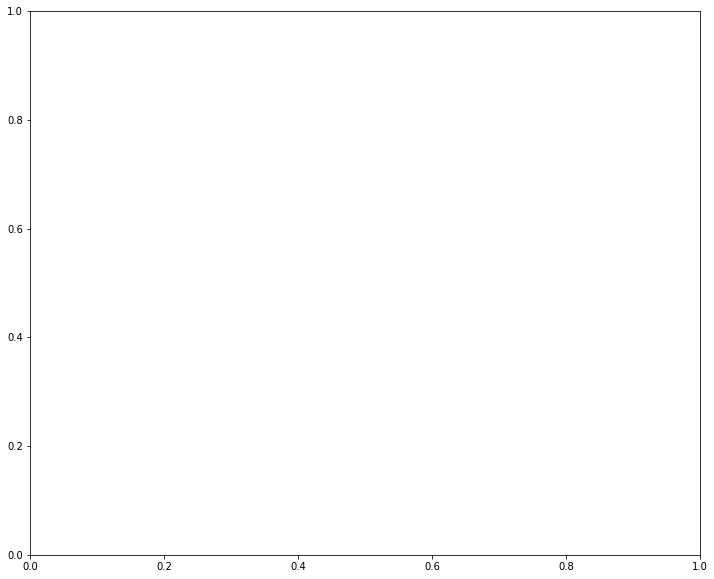

In [29]:
plot_results(models,
                 data,
                 batch_size=32,
                 model_name="vae_mlp")

In [ ]:
def plot_autoencoder_outputs(encoder,k, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    #x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    #n = 5
    j=100
    plt.figure(figsize=(20, 5))
    for i in range(k, n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
        j=j+1
    plt.show()

In [30]:
x_test_encoded = vae.predict(x_test, batch_size = 32)

In [ ]:
print(x_test_encoded[100].shape)

In [ ]:
x_test_encoded2 = vae.predict(x_test_3, batch_size = 32)

In [ ]:
x_test_encoded

In [ ]:
#plot_autoencoder_outputs(x_test_encoded, 15, 20, (704,624))

In [ ]:
print(np.amax(x_test_encoded))
print(np.amin(x_test_encoded))

#x_test_encoded[:] = [x * 10 for x in x_test]

print(np.amax(x_test_encoded))
print(np.amin(x_test_encoded))

In [ ]:
vae_test.set_weights(vae.get_weights())

from random import shuffle

#shuffle(x_test)

score = vae_test.evaluate(x_test, x_test, verbose=1, batch_size=32,steps=None)
#score = vae.evaluate(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
print(x_test.shape)
print(x_test.reshape(416,12,2,176,112)

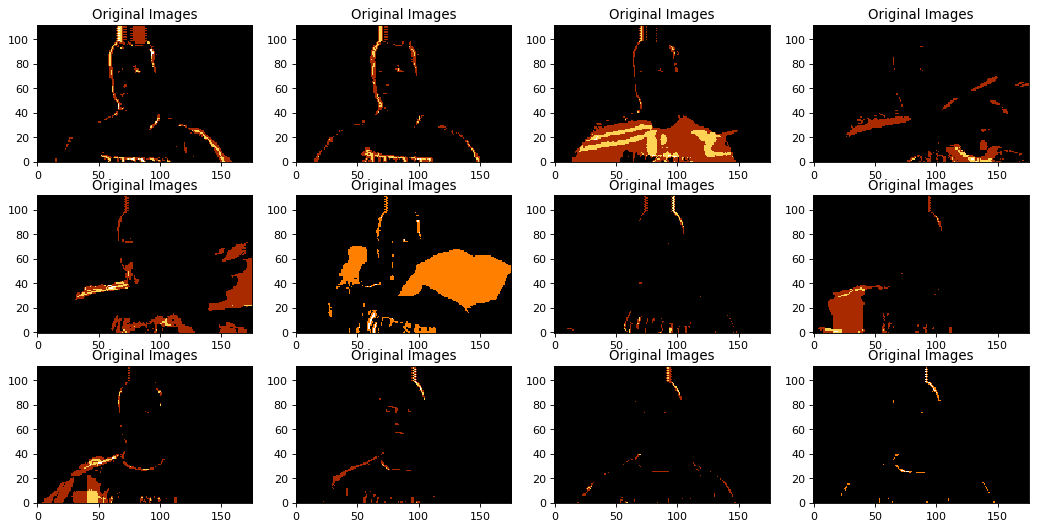

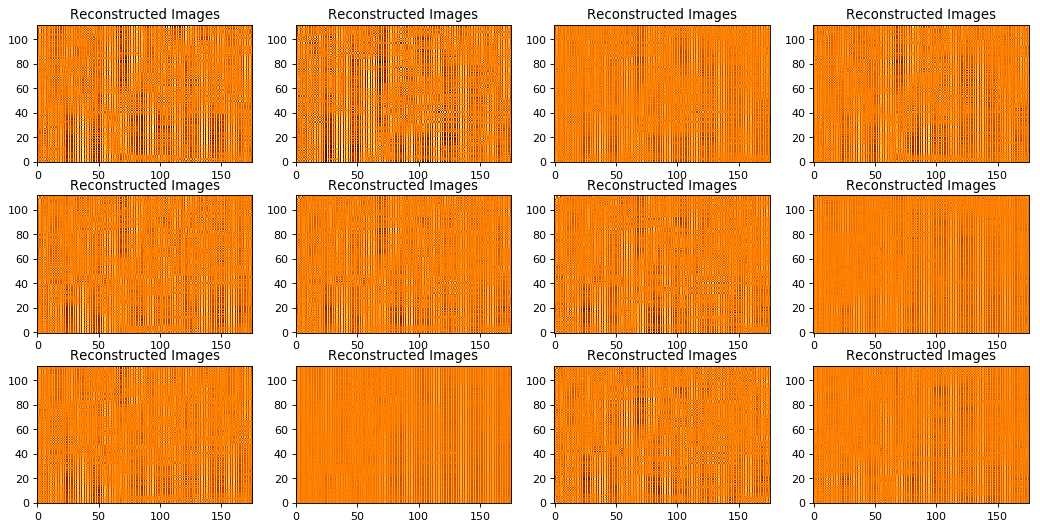

In [31]:
#Visualisation in 12 chunks
A0= x_test.reshape(416,12,2,112,176)
A = A0[120]
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3,4, i + 1)
    ax.set_title('Original Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

    
#Visualisation in 12 chunks
A1= x_test_encoded.reshape(416,12,2,112,176)
A = A1[120]
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title('Reconstructed Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1)

In [ ]:
x_test_encoded2 = vae.predict(x_test_3, batch_size = 32)

A= x_test_3[100].reshape(12,2,112,176)
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title('Original Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

    
#Visualisation in 12 chunks
A= x_test_encoded2[100].reshape(12,2,112,176)
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title('Reconstructed Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

In [ ]:
print(x_test_encoded2[10])

In [ ]:
import pandas as pd
plot_loss(history)

In [ ]:
plot_compare_histories(history, 1, plot_accuracy=True)

In [ ]:
# #Visualisation in 12 chunks
# A= x_test_encoded[100].reshape(12,2,104,176)
# fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
# for cnt,i in enumerate(range(12)):
#     ax = plt.subplot(3, 4, i + 1)
#     plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
#     plt.gca().invert_yaxis()
#     #plt.savefig("mytable{}.png".format(cnt*2))
#     plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
#     plt.gca().invert_yaxis()
#     #plt.savefig("mytable{}.png".format((cnt*2)+1))

In [ ]:
#Visualisation in 12 chunks
A= x_test_encoded[10].reshape(12,2,112,176)
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

In [ ]:
# score2 = vae_test.score(x_test, x_test, verbose=1, batch_size=32,steps=None)
# #score = vae.evaluate(x_test)
# print('Test loss:', score2[0])
# print('Test accuracy:', score2[1])